The database is composed by several CSV (Comma-Separated Values) files, each one with 8 columns, one column for each sensor, according to:

column 1 tachometer signal that allows to estimate rotation frequency;

columns 2 to 4 underhang bearing accelerometer (axial, radiale tangential direction);

columns 5 to 7 overhang bearing accelerometer (axial, radiale tangential direction);

column 8 microphone.

source: https://www02.smt.ufrj.br/~offshore/mfs/page_01.html

According to the description of the columns there are not one two radial orthogonal accelerometers. Thus, it is not possible to observe the movement orbit of the rotating machine.

On the other hand, perhaps the tangential accelerometer is also moving radially, therefore orthogonal to the radial accelerometer.

Soft-DTW é uma função de perda diferenciável usada em análise de séries temporais, baseada no Dynamic Time Warping (DTW). Permite comparar séries de tamanhos variáveis, é robusta a deslocamentos e dilatações no tempo, e pode ser usada em aprendizado de máquina para tarefas como média, clustering e previsão.


### Desbalanceamento com 20g

- Instalação do soft-DTW:

1 - activate a venv
2 - pip install --upgrade pip setuptools wheel
3 - pip install numpy cython
4 - pip install soft-dtw

In [1]:
# pip install soft-dtw

In [1]:
pip show soft-dtw

Name: soft-dtw
Version: 0.1.6
Summary: Python implementation of soft-DTW
Home-page: https://github.com/mblondel/soft-dtw/
Author: 
Author-email: 
License: Simplified BSD
Location: d:\IFSP\Matematica - Aulas\Codes\math\Lib\site-packages
Requires: chainer, cython, numpy, scikit-learn, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
# import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# from tensorflow.keras import layers, models
# from tensorflow.keras.utils import plot_model
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#### 1 - df_overhang

- Usaremos apenas a classificação ball_fault de peso 20g

In [4]:
# df_20g = "C:/Files/mafaulda_full/overhang/ball_fault/20g"
# df_normal = "C:/Files/mafaulda_full/normal"
df_overhang = "C:/Files/mafaulda_bas/overhang_small/ball_fault/20g"

#### 1.1 - Concatenação:

In [5]:
# Lista para armazenar os DataFrames

dataframes = []

# Verifica se o caminho fornecido é um diretório válido
if os.path.isdir(df_overhang):
    # Iterar pelos arquivos no diretório
    for filename in os.listdir(df_overhang):
        if filename.endswith(".csv"): 
            file_path = os.path.join(df_overhang, filename)
            
            try:
                # Lendo o arquivo CSV, pulando a primeira linha (cabeçalho).
                # O parâmetro skiprows=1 é a chave para resolver o problema do 'object' dtype.
                df = pd.read_csv(file_path, sep=',', header=None, skiprows=1)
                dataframes.append(df)
            except Exception as e:
                print(f"Não foi possível ler o arquivo {filename}: {e}")


    if dataframes:
        #Concatenando os dataframes em um único:
        df_overhang_concat = pd.concat(dataframes, ignore_index=True)

        # Mostrando as primeiras linhas e tipos de dados:
        print("__Dataframe combinado (df_overhang) ___")
        print(df_overhang_concat.head())
        print("\n--- Tipos de dados (dtypes) ---")
        print(df_overhang_concat.dtypes)
    else:
        print("Não houve leitura de arquivos")
else:
    print(f"diretório df_desbalanceado_20g não encontrado: {df_overhang}")
    


__Dataframe combinado (df_overhang) ___
         0         1        2       3
0 -0.70079 -0.225680  0.66893  1.3654
1 -0.81775 -0.268090  0.50473  1.2441
2 -0.65120 -0.157050  0.55160  1.2579
3 -0.79085 -0.137450  0.44238  1.1917
4 -0.81586 -0.077372  0.39454  1.1675

--- Tipos de dados (dtypes) ---
0    float64
1    float64
2    float64
3    float64
dtype: object


- Supondo ultima coluna como rotulos ou classes (y) e as demais como features (X):

In [6]:

X = df_overhang_concat.iloc[:, :].values         # Todas as colunas
#y = df_unbalance_20g_concat.iloc[:, -1]         # Apenas a última coluna
y = np.full(X.shape[0], 1)  # Criando um array de rótulos com valor 1 para todas as amostras


In [7]:
print("--- Verificação de X e y ---")
# Para NumPy arrays, usamos fatiamento para ver o "cabeçalho" e .dtype para o tipo de dado
print("X head:\n", X[:5]) # Mostra as primeiras 5 linhas (fatiamento de array)
print("\nX numpy dtype:", X.dtype) # Mostra o tipo de dado do array NumPy
print("\ny head:\n", y[:5]) # Mostra as primeiras 5 linhas de y
print("\ny dtypes:", y.dtype) # Mostra o tipo de dado do array NumPy
print('--------------------------------------')
print("X shape:", X.shape)
print("y shape:", y.shape)
print('--------------------------------------')
print('ooooooooooooooooooooooooooooooooooooo')


--- Verificação de X e y ---
X head:
 [[-0.70079  -0.22568   0.66893   1.3654  ]
 [-0.81775  -0.26809   0.50473   1.2441  ]
 [-0.6512   -0.15705   0.5516    1.2579  ]
 [-0.79085  -0.13745   0.44238   1.1917  ]
 [-0.81586  -0.077372  0.39454   1.1675  ]]

X numpy dtype: float64

y head:
 [1 1 1 1 1]

y dtypes: int64
--------------------------------------
X shape: (6249975, 4)
y shape: (6249975,)
--------------------------------------
ooooooooooooooooooooooooooooooooooooo


#### 1.2 - Normalização:

- É um comportamento esperado do pandas. Essa linha não se refere a uma coluna específica do seu DataFrame. Ela descreve o tipo de dados da própria lista de tipos que está sendo exibida. Como a lista contém vários objetos de tipo float64 e outros, o pandas a classifica como uma série de tipo object.
- fit (Ajustar/Aprender): A primeira parte, fit, "olha" para cada coluna (cada sensor), calcula a média (μ) e o desvio padrão (σ) daquela coluna específica, aprendendo os parâmetros de distribuição dos dados.

In [ ]:
# Função para normalizar os dados. preprocess_data padroniza os dados antes de entregá-los ao modelo para tr

print("\n1. Aplicando a normalização (StandardScaler) aos dados de X...")

def preprocess_data(data_to_scale):                                  # X  é o conjunto de dados de entrada (as leituras dos 8 sensores de vibração
    print("   'X_scaled' foi criado com sucesso!")
    scaler = StandardScaler()
    scaled_data_out = scaler.fit_transform(data_to_scale)
        
    # VISUALIZAR OS DADOS NORMALIZADOS
    print("\n2. Gerando gráficos para visualização...")
    return scaled_data_out


1. Aplicando a normalização (StandardScaler) aos dados de X...


### 1.3 - Análise do sinal do acelerômetro Overhang com peso de 20g:

In [9]:
# print("\n1. Aplicando a normalização (StandardScaler) aos dados de X...")
X_scaled = preprocess_data(X)   # <--- CHAMA A FUNÇÃO E OBTÉM O RESULTADO
print("   'X_scaled' foi criado com sucesso!")
print(f"   Formato do X_scaled: {X_scaled.shape}, Tipo: {type(X_scaled)}")
print('-----------------------------------------')

# --- VISUALIZAR OS DADOS NORMALIZADOS (Plotagem) ---
print("\n2. Gerando gráficos para visualização...")


   'X_scaled' foi criado com sucesso!

2. Gerando gráficos para visualização...
   'X_scaled' foi criado com sucesso!
   Formato do X_scaled: (6249975, 4), Tipo: <class 'numpy.ndarray'>
-----------------------------------------

2. Gerando gráficos para visualização...


PLOTAGEM COM TEMPO INICIAL CURTO


C:\Users\carlo\AppData\Local\Temp\ipykernel_20328\2434057876.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


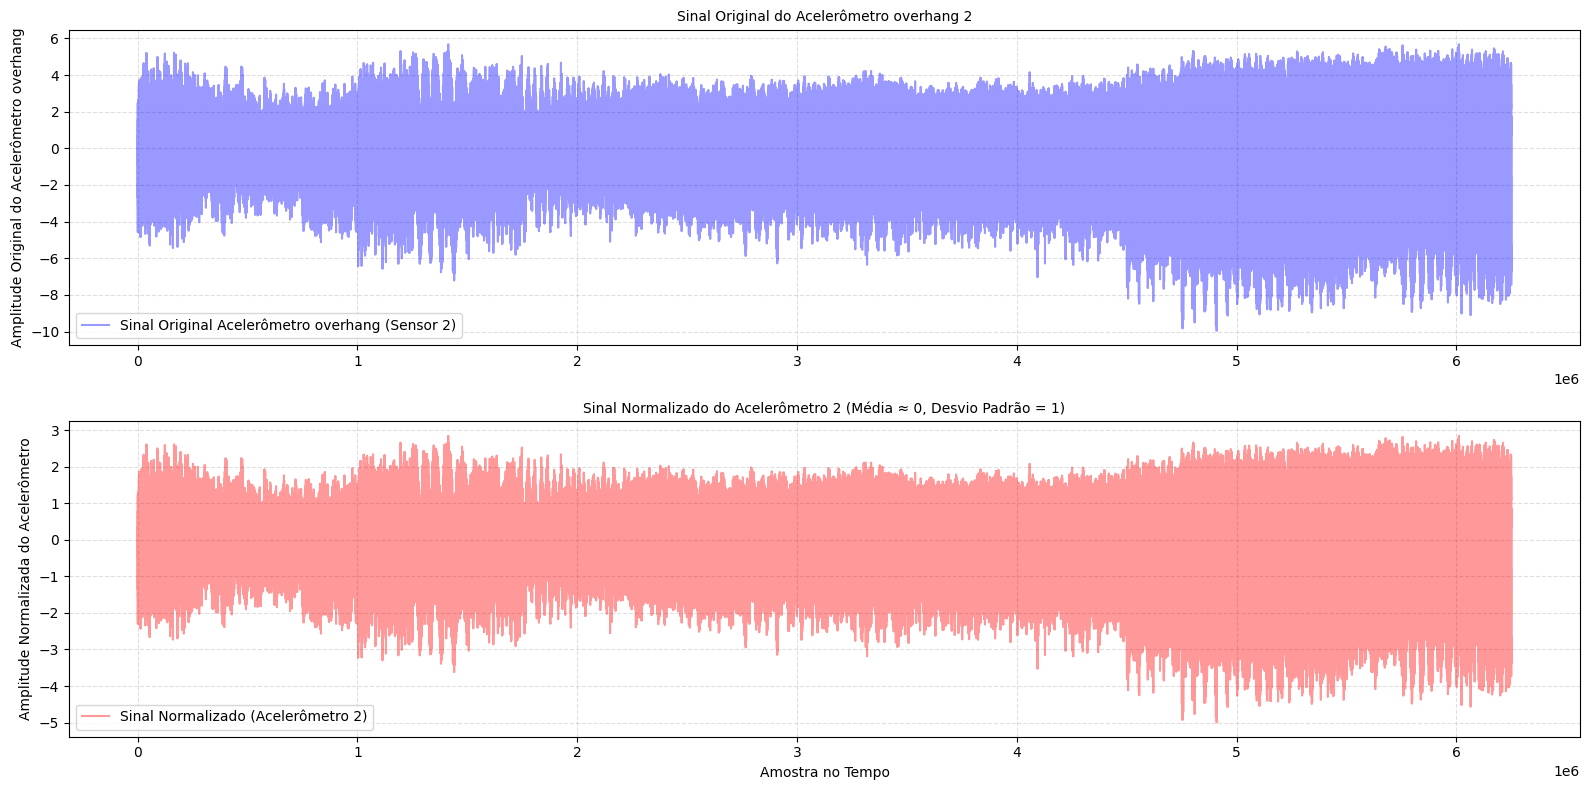

PLOTAGEM COM TEMPO INICIAL LONGO


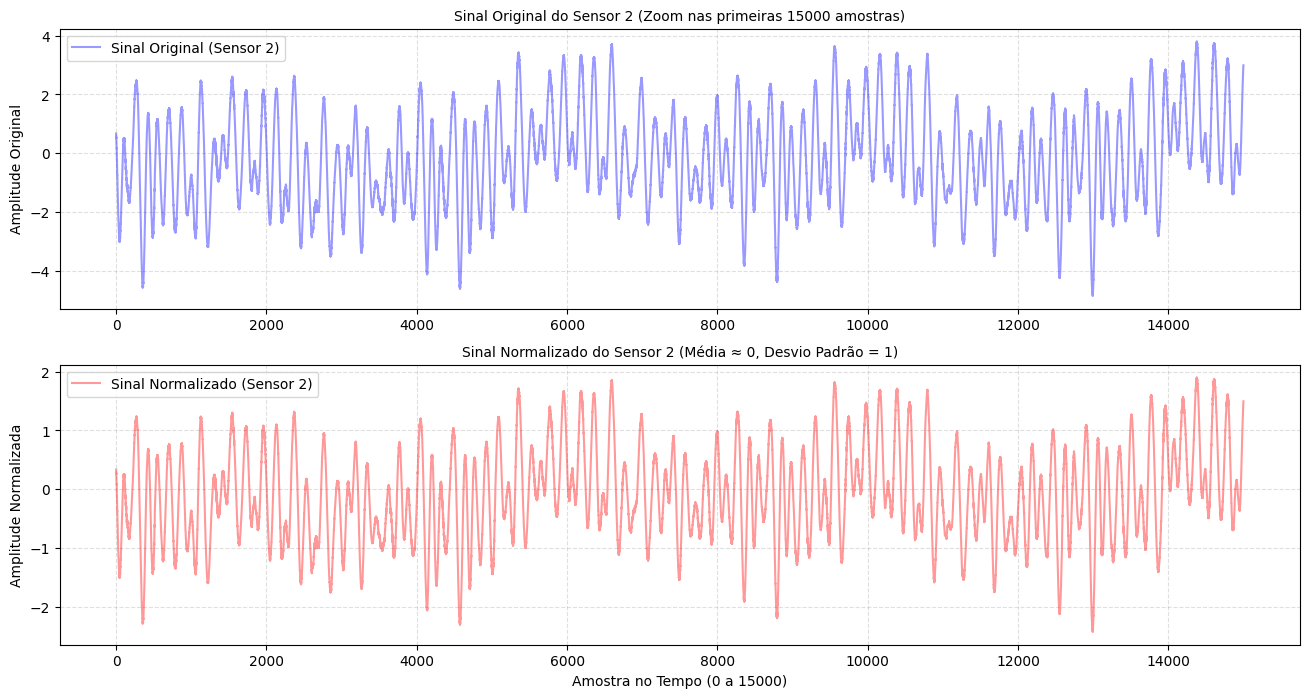

In [15]:


sensor_a_visualizar = 2 # acelerômetro overhang sinal radial.


# Acessa os dados originais (X deve ser um array NumPy)
raw_overhang_signal = X[:, sensor_a_visualizar]
# Acessa os dados já escalados
scaled_overhang_signal = X_scaled[:, sensor_a_visualizar]

# --- Gráfico 1: Comparação do Sinal no Tempo ---
plt.figure(figsize=(16, 8))





# plotagem com tempo inicial curto:
print("PLOTAGEM COM TEMPO INICIAL CURTO")

# Gráfico do sinal original
plt.subplot(2, 1, 1)
plt.plot(raw_overhang_signal, label=f'Sinal Original Acelerômetro overhang (Sensor {sensor_a_visualizar})', color='blue', alpha=0.4)
plt.title(f'Sinal Original do Acelerômetro overhang {sensor_a_visualizar}', fontsize=10)
plt.ylabel('Amplitude Original do Acelerômetro overhang', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Gráfico do sinal normalizado
plt.subplot(2, 1, 2)
plt.plot(scaled_overhang_signal, label=f'Sinal Normalizado (Acelerômetro {sensor_a_visualizar})', color='red', alpha=0.4)
plt.title(f'Sinal Normalizado do Acelerômetro {sensor_a_visualizar} (Média ≈ 0, Desvio Padrão = 1)', fontsize=10)
plt.xlabel('Amostra no Tempo', fontsize=10)
plt.ylabel('Amplitude Normalizada do Acelerômetro', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()



# plotagem com tempo inicial LONGO:

num_amostras_plot = 15000


print("PLOTAGEM COM TEMPO INICIAL LONGO")

plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
# Aplica o fatiamento com o novo número de amostras
plt.plot(raw_overhang_signal[:num_amostras_plot], label=f'Sinal Original (Sensor {sensor_a_visualizar})', color='blue', alpha=0.4)
plt.title(f'Sinal Original do Sensor {sensor_a_visualizar} (Zoom nas primeiras {num_amostras_plot} amostras)', fontsize=10)
plt.ylabel('Amplitude Original', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Gráfico do sinal normalizado
plt.subplot(2, 1, 2)
# Aplica o fatiamento com o novo número de amostras
plt.plot(scaled_overhang_signal[:num_amostras_plot], label=f'Sinal Normalizado (Sensor {sensor_a_visualizar})', color='red', alpha=0.4)
plt.title(f'Sinal Normalizado do Sensor {sensor_a_visualizar} (Média ≈ 0, Desvio Padrão = 1)', fontsize=10)
plt.xlabel(f'Amostra no Tempo (0 a {num_amostras_plot})', fontsize=10)
plt.ylabel('Amplitude Normalizada', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

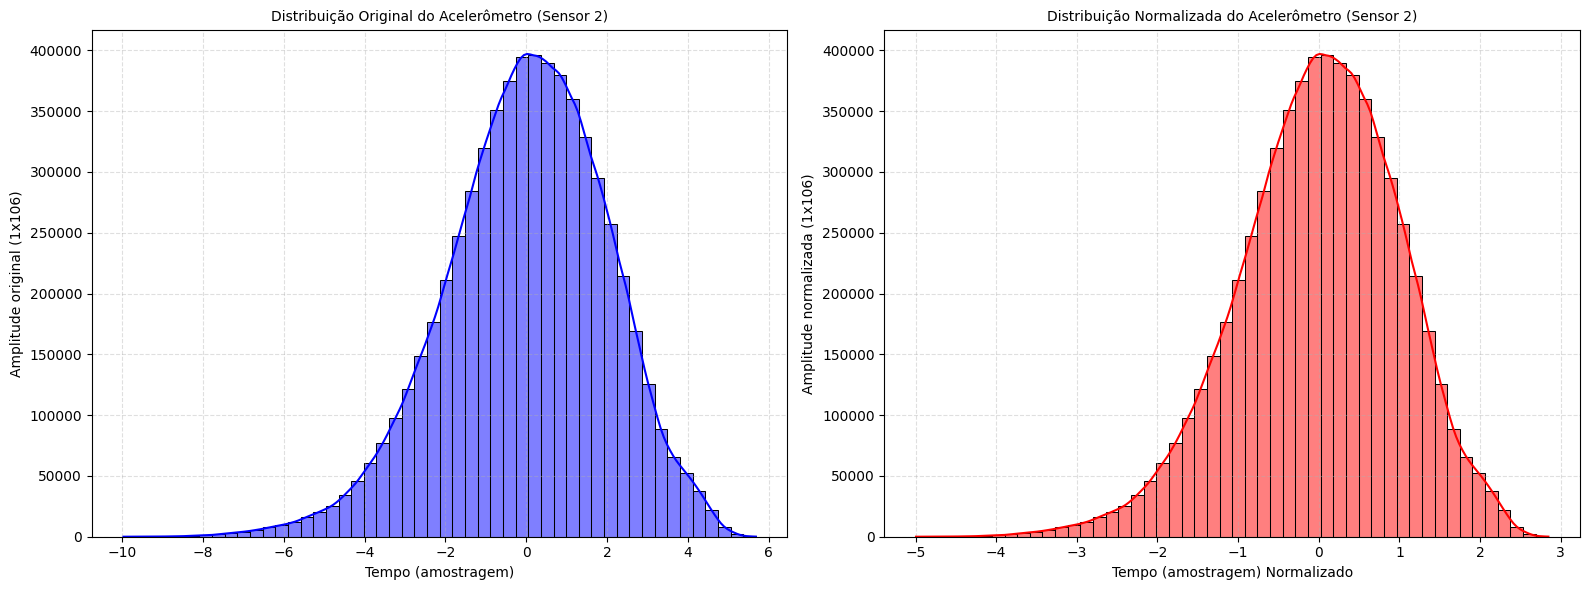


Visualização concluída.


In [12]:
# --- Gráfico 2: Comparação da Distribuição dos Dados (Histograma) ---
plt.figure(figsize=(16, 6))

# Histograma do sinal original
plt.subplot(1, 2, 1)
sns.histplot(raw_overhang_signal, kde=True, color='blue', bins=50)
plt.title(f'Distribuição Original do Acelerômetro (Sensor {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Tempo (amostragem)', fontsize=10)
plt.ylabel('Amplitude original (1x106)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)

# Histograma do sinal normalizado
plt.subplot(1, 2, 2)
sns.histplot(scaled_overhang_signal, kde=True, color='red', bins=50)
plt.title(f'Distribuição Normalizada do Acelerômetro (Sensor {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Tempo (amostragem) Normalizado', fontsize=10)
plt.ylabel('Amplitude normalizada (1x106)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

print("\nVisualização concluída.")

### Métricas Estatísticas:

#### Tecnicas no domınio da frequencia: Analise espectral

- O processo da analise espectral se inicia com a aquisiçao do sinal de vibraçao por intermedio de um acelerometro. Este sinal, no domınio do tempo, sera transformado para o domınio da frequencia atraves do procedimento da Transformada Rapida de Fourier (FFT). Ja no domınio da frequencia, analisa-se o sinal procurando pelos picos mais protuberantes. As frequencias dependentes da rotaçao de trabalho, chamados de harmonicos, sao expressas de forma relativa e nao absoluta como 1x (uma vez a rotaçao da maquina), 2x, 3x, etc.

#### Transformada de fourier:

- Incluir libraries:

In [16]:
from scipy.fft import rfft, rfftfreq
from scipy import integrate

#### Transformada Rápida de Fourier (rFFT)

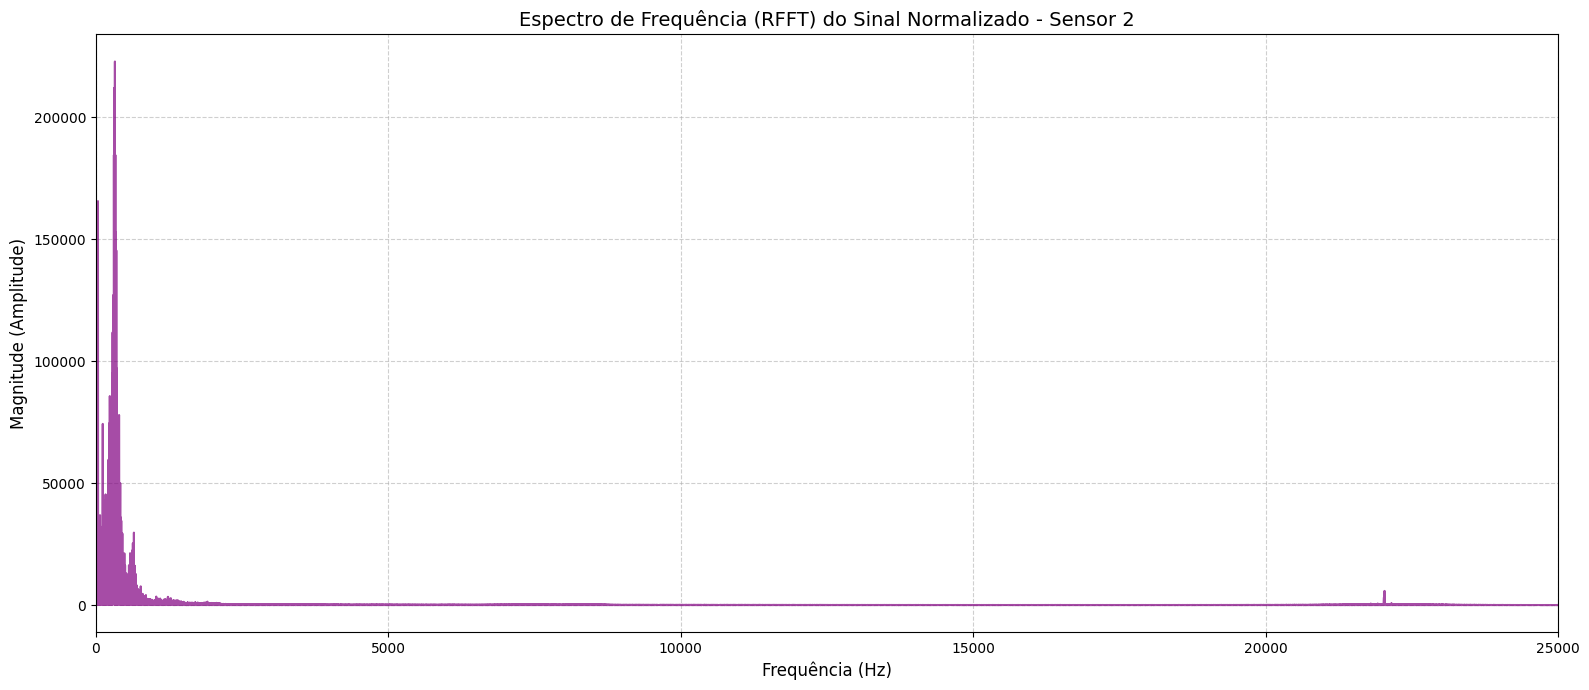


Plotagem da RFFT concluída.


In [18]:
TAXA_AMOSTRAGEM = 50000 # Hz (50 kHz) 

# 1. Calcular a Transformada Rápida de Fourier Real (RFFT)
fft_values = rfft(scaled_overhang_signal)

# 2. Calcular as frequências correspondentes aos valores da FFT onde N é o núm. de pontos no sinal de tempo
N = len(scaled_overhang_signal)
frequencies = rfftfreq(N, 1 / TAXA_AMOSTRAGEM)

# --- Plotagem da Magnitude da RFFT ---
plt.figure(figsize=(16, 7))
plt.plot(frequencies, np.abs(fft_values), color='purple', alpha=0.7)
plt.title(f'Espectro de Frequência (RFFT) do Sinal Normalizado - Sensor {sensor_a_visualizar}', fontsize=14)
plt.xlabel('Frequência (Hz)', fontsize=12)
plt.ylabel('Magnitude (Amplitude)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, TAXA_AMOSTRAGEM / 2) # Limita o eixo X à frequência de Nyquist
plt.tight_layout()
plt.show()

print("\nPlotagem da RFFT concluída.")

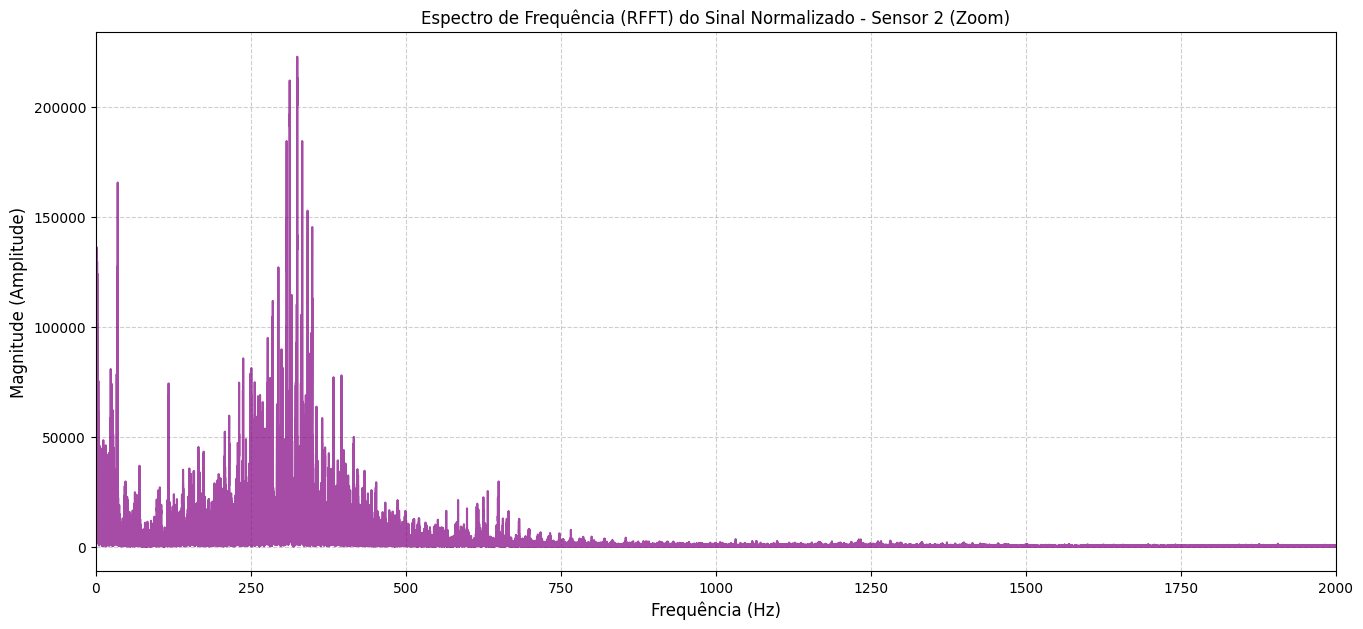

In [20]:
#Dando um zoom na região de interesse (até 2 KHz.)

# --- Plotagem da Magnitude da RFFT com Zoom ---
plt.figure(figsize=(16, 7))
plt.plot(frequencies, np.abs(fft_values), color='purple', alpha=0.7)
plt.title(f'Espectro de Frequência (RFFT) do Sinal Normalizado - Sensor {sensor_a_visualizar} (Zoom)', fontsize=12)
plt.xlim(0, 2000)
plt.xlabel('Frequência (Hz)', fontsize=12)
plt.ylabel('Magnitude (Amplitude)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

Análise do Espectro de Frequência (RFFT) para um Sinal de Rolamento com Defeito (scale_overhang_signal):

Este espectro representa a distribuição da energia vibracional em diferentes frequências do sinal normalizado do sensor no overhang.

Observação Geral:

Eixo X (Frequência em Hz): Representa as frequências das componentes vibracionais.
Eixo Y (Magnitude): Representa a amplitude ou intensidade dessas componentes vibracionais em cada frequência. Picos mais altos indicam maior energia vibracional em uma frequência específica.
Identificação de Frequências de Falha de Rolamentos:

Rolamentos com defeito geram impulsos (impactos) que se repetem a frequências específicas, conhecidas como Frequências de Falha de Rolamento. As principais são:
BPFI (Ball Pass Frequency Inner race): Frequência de passagem dos elementos rolantes por um defeito na pista interna.
BPFO (Ball Pass Frequency Outer race): Frequência de passagem dos elementos rolantes por um defeito na pista externa.
BSF (Ball Spin Frequency): Frequência de giro dos elementos rolantes em torno do seu próprio eixo.
FTF (Fundamental Train Frequency): Frequência de giro da gaiola do rolamento.
No espectro da RFFT de um rolamento com defeito, esperaríamos ver:
Picos em frequências de ressonância da estrutura: Os impactos de um rolamento com defeito tendem a "tocar" ou excitar as frequências naturais de ressonância da máquina (e.g., carcaça, eixo). Esses picos geralmente são de alta frequência e de banda larga, e servem como "portadora" para as frequências de falha.
Bandas laterais (sidebands) ao redor das frequências de ressonância: Mais importante para o diagnóstico de rolamentos em um espectro de vibração bruto (como o RFFT plotado), são as bandas laterais que aparecem ao redor dos picos de ressonância. Essas bandas laterais são espaçadas pelas frequências de falha do rolamento (BPFO, BPFI, BSF, FTF). Por exemplo, se há um defeito na pista externa (BPFO), você pode ver um pico de ressonância com "cópias" menores em (Frequência_Ressonância ± BPFO), (Frequência_Ressonância ±2× BPFO), etc.
Picos na frequência de rotação (1X RPM) e seus harmônicos: Embora menos diretos para falhas de rolamento puro, podem indicar desbalanceamento, desalinhamento, ou a forma como a vibração do rolamento está interagindo com a rotação do eixo.
Análise Visual do Gráfico Fornecido:

A imagem mostra uma concentração de energia em certas faixas de frequência, com picos visíveis. Sem os valores exatos de frequência no eixo X para os picos, e sem as especificações do rolamento para calcular BPFO/BPFI/BSF/FTF, é difícil fazer um diagnóstico preciso.
No entanto, a presença de múltiplos picos e uma distribuição complexa de energia é típica de sinais de vibração. A identificação de padrões de bandas laterais ou picos em frequências específicas (se as identificarmos no eixo X) seria o próximo passo.
Próximos Passos para Análise de Falhas em Rolamentos Usando este Espectro:

Para uma análise mais conclusiva, seria necessário:

Conhecer a frequência de rotação da máquina (RPM) para identificar o 1X RPM e seus harmônicos.
Ter as especificações do rolamento para calcular as frequências de falha teóricas (BPFO, BPFI, BSF, FTF).
Realizar um zoom na região dos picos mais proeminentes para observar a existência de padrões de bandas laterais espaçadas pelas frequências de falha do rolamento.
Considerar a Análise de Envelope (TH + FFT): Para falhas de rolamento, a técnica mais robusta para isolar e diagnosticar os defeitos é frequentemente a Transformada de Hilbert seguida da FFT do envelope, pois esta técnica é projetada especificamente para demodular os impactos repetitivos.

In [81]:
overhang = scaled_overhang_signal

In [82]:
N = overhang.shape[0]

def acel_spectrum(x_acel):
    x_acel = x_acel - np.mean(x_acel)

    yf = rfft(x_acel)
    xf = rfftfreq(N, 1 / SAMPLE_RATE)

    plt.plot(xf, np.abs(yf))
    plt.title("Accel_Spectrum")
    plt.show()


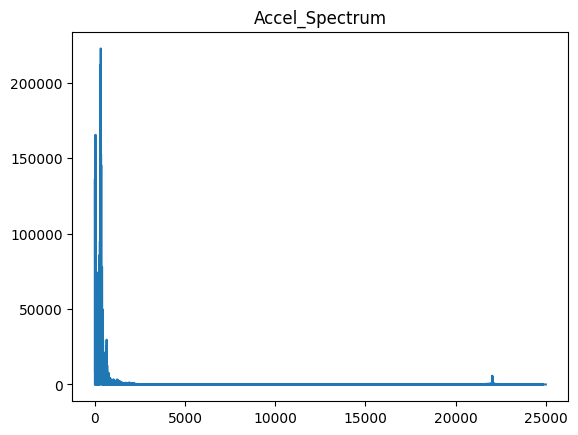

In [83]:
SAMPLE_RATE = TAXA_AMOSTRAGEM
acel_spectrum(overhang)


--- Gerando Espectro de Aceleração Normalizado ---


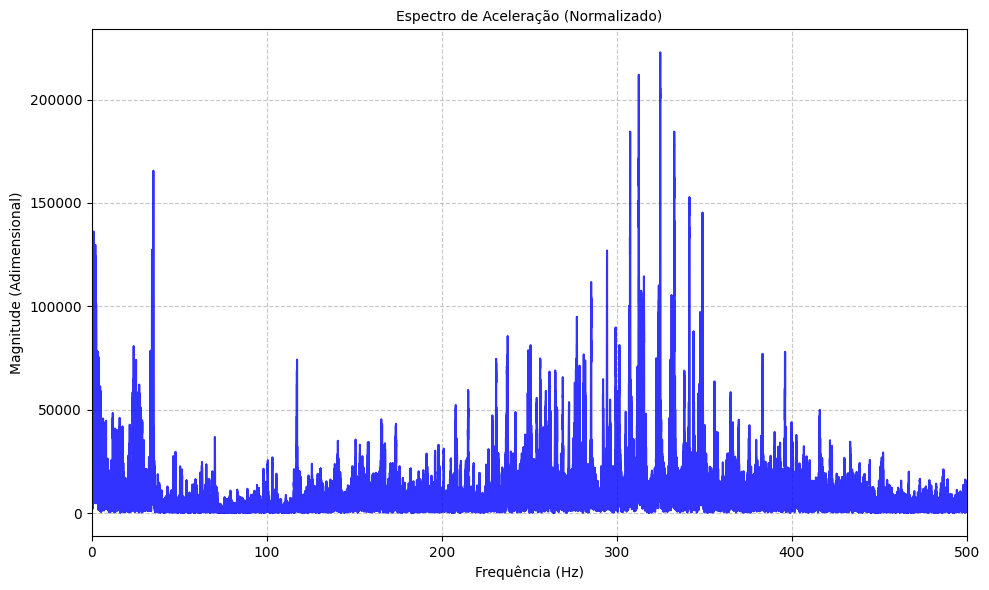


Algoritmo de plotagem do espectro de aceleração concluído.


In [92]:
# 'scaled_overhang_signal', ou o sinal do acelerômetro normalizado.

def acel_spectrum(x_acel):
    """
    Calcula o espectro de aceleração a partir de um sinal de aceleração normalizado,
    removendo a média e aplicando a RFFT.
    """
    #Remover a média (componente DC) do sinal normalizado, se ainda não foi removida ou para garantir.
    x_acel = x_acel - np.mean(x_acel)

    yf = rfft(x_acel)
    # CORREÇÃO: N para rfftfreq deve ser o comprimento do sinal x_acel
    N_signal = len(x_acel)
    xf = rfftfreq(N_signal, 1 / SAMPLE_RATE)

    # --- Plotagem do Espectro de Aceleração com Unidades ---
    plt.figure(figsize=(10, 6)) # Define o tamanho da figura para melhor visualização
    plt.plot(xf, np.abs(yf), color='blue', alpha=0.8) # Plota a magnitude do espectro
    plt.title("Espectro de Aceleração (Normalizado)", fontsize=10)
    plt.xlabel("Frequência (Hz)", fontsize=10) 
    plt.ylabel("Magnitude (Adimensional)", fontsize=10) 
    
    # Definir limites de plotagem em uma faixa de interesse específica.
    plt.xlim([0, SAMPLE_RATE / 2]) # Para mostrar até a frequência de Nyquist
    plt.xlim([0, 500]) # zoom até 500 Hz
    
    plt.grid(True, linestyle='--', alpha=0.7) # Adiciona grade
    plt.tight_layout() # Ajusta o layout para evitar sobreposição
    plt.show() # Exibe o gráfico

# --- CHAMADA DA FUNÇÃO NO ESCOPO GLOBAL ---
print("\n--- Gerando Espectro de Aceleração Normalizado ---")
acel_spectrum(scaled_overhang_signal)

print("\nAlgoritmo de plotagem do espectro de aceleração concluído.")

In [96]:
from scipy.signal import butter, filtfilt

# Desenvolvimento de um FPB:
if 'SAMPLE_RATE' not in locals(): #se taxa de amostragem não presente....
    
    SAMPLE_RATE = 52000 # Hz
    
# Se 'scaled_overhang_signal' não estiver definido, avisa e ENCERRA.
if 'scaled_overhang_signal' not in locals() and 'scaled_overhang_signal' not in globals():
    print("ERRO: 'scaled_overhang_signal' não encontrado.")
    
    raise SystemExit("Execução interrompida devido à ausência de 'scaled_overhang_signal'.")
    
print("\n--- Aplicando Filtro Passa-Banda ao Sinal do Acelerômetro Normalizado ---")



--- Aplicando Filtro Passa-Banda ao Sinal do Acelerômetro Normalizado ---


#### --- 1. Definir Parâmetros do Filtro Passa-Banda ---

In [118]:
# Deve-se definir a banda de ressonância da sua máquina.
# Estes são valores EXEMPLO:
fc_low = 50  # Frequência de corte inferior (Hz) - Exemplo: 2 kHz
fc_high = 2000 # Frequência de corte superior (Hz) - Exemplo: 8 kHz
order = 3      # Ordem do filtro (quanto maior, mais íngreme o corte, mas pode introduzir mais atraso)

#### 2. Normalizar as Frequências de Corte

In [119]:
# As frequências de corte são normalizadas pela frequência de Nyquist (SAMPLE_RATE / 2).
nyquist = 0.5 * SAMPLE_RATE
normal_fc_low = fc_low / nyquist
normal_fc_high = fc_high / nyquist

#### 3. Projetar o Filtro Butterworth Passa-Banda

In [120]:
# 'b' e 'a' são os coeficientes do numerador e denominador do filtro.
b, a = butter(order, [normal_fc_low, normal_fc_high], btype='band', analog=False)

#### 4. Aplicar o Filtro ao Sinal

In [121]:

# 'filtfilt' aplica o filtro para frente e para trás, eliminando o atraso de fase.
signal_filtered = filtfilt(b, a, scaled_overhang_signal)

print(f"Filtro Passa-Banda aplicado: {fc_low}-{fc_high} Hz, Ordem: {order}")

Filtro Passa-Banda aplicado: 50-2000 Hz, Ordem: 3


#### --- 5. Plotar o Sinal Original e o Sinal Filtrado (Zoom no Tempo) ---

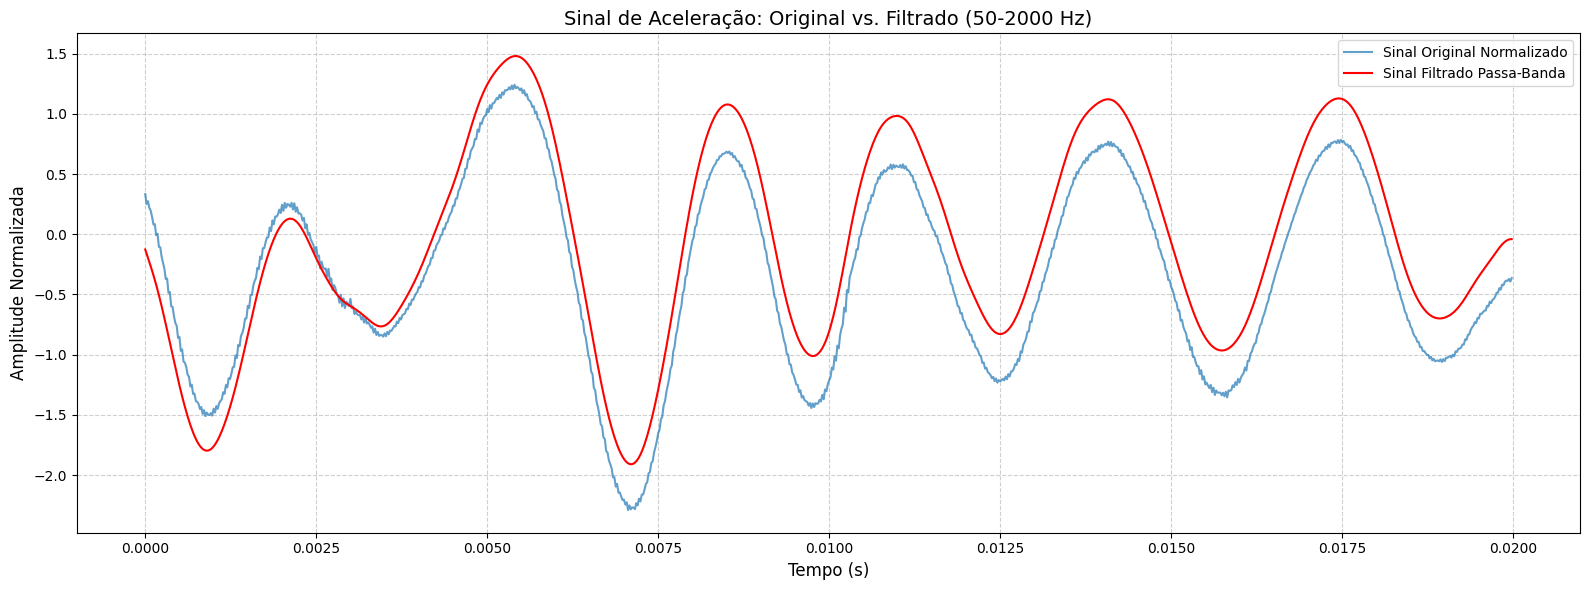

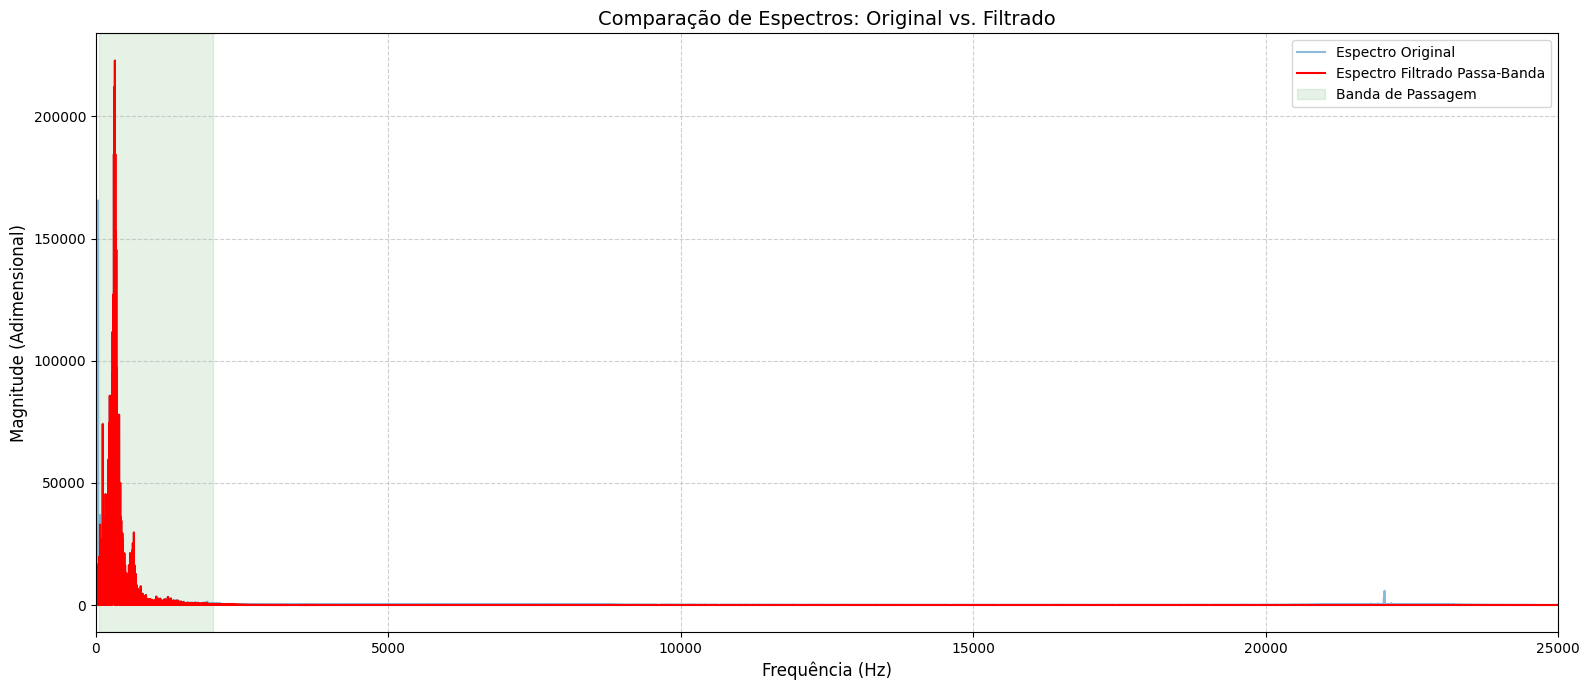


Filtro Passa-Banda aplicado e espectros comparados. O sinal 'signal_filtered' está pronto para a próxima etapa (e.g., Transformada de Hilbert para análise de envelope).


In [122]:
num_amostras_zoom_plot = 1000 # Para melhor visualização no tempo
t_axis = np.arange(num_amostras_zoom_plot) / SAMPLE_RATE

plt.figure(figsize=(16, 6))
plt.plot(t_axis, scaled_overhang_signal[:num_amostras_zoom_plot], label='Sinal Original Normalizado', alpha=0.7)
plt.plot(t_axis, signal_filtered[:num_amostras_zoom_plot], label='Sinal Filtrado Passa-Banda', color='red', linewidth=1.5)
plt.title(f'Sinal de Aceleração: Original vs. Filtrado ({fc_low}-{fc_high} Hz)', fontsize=14)
plt.xlabel('Tempo (s)', fontsize=12)
plt.ylabel('Amplitude Normalizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 6. Plotar os Espectros (Original vs. Filtrado) para Análise em Frequência ---
N_fft = len(scaled_overhang_signal)
xf_original, yf_original = rfftfreq(N_fft, 1/SAMPLE_RATE), np.abs(rfft(scaled_overhang_signal))
xf_filtered, yf_filtered = rfftfreq(N_fft, 1/SAMPLE_RATE), np.abs(rfft(signal_filtered))

plt.figure(figsize=(16, 7))
plt.plot(xf_original, yf_original, label='Espectro Original', alpha=0.5)
plt.plot(xf_filtered, yf_filtered, label='Espectro Filtrado Passa-Banda', color='red', linewidth=1.5)
plt.axvspan(fc_low, fc_high, color='green', alpha=0.1, label='Banda de Passagem') # Destaca a banda
plt.title('Comparação de Espectros: Original vs. Filtrado', fontsize=14)
plt.xlabel('Frequência (Hz)', fontsize=12)
plt.ylabel('Magnitude (Adimensional)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, nyquist) # Mostra todo o espectro até Nyquist
# Opcional: plt.xlim(0, 10000) # Para um zoom visual onde a banda de passagem estaria
plt.tight_layout()
plt.show()

print("\nFiltro Passa-Banda aplicado e espectros comparados. O sinal 'signal_filtered' está pronto para a próxima etapa (e.g., Transformada de Hilbert para análise de envelope).")